In [45]:
#packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [46]:
df=pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     755 non-null    int64
 1   tempMode     755 non-null    int64
 2   AQ           755 non-null    int64
 3   USS          755 non-null    int64
 4   CS           755 non-null    int64
 5   VOC          755 non-null    int64
 6   RP           755 non-null    int64
 7   IP           755 non-null    int64
 8   Temperature  755 non-null    int64
 9   fail         755 non-null    int64
dtypes: int64(10)
memory usage: 59.1 KB


In [47]:
df.isnull().sum()

footfall       0
tempMode       0
AQ             0
USS            0
CS             0
VOC            0
RP             0
IP             0
Temperature    0
fail           0
dtype: int64

In [48]:
df.describe()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000,755.000000
mean,318.109934,3.770861,4.309934,2.968212,5.388079,2.774834,47.054305,4.566887,16.247682,0.405298
std,1108.393112,2.655598,1.437226,1.387342,1.287201,2.253710,16.616871,1.578777,6.046316,0.491275
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.500000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,13.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000


See that the dataset is already clean, same values, and for now the rest of the ariables seem ok. 

In [49]:
matrix=df.corr(method='pearson').round(2)
#matrix.style.background_gradient()
fig=px.imshow(
    matrix,
    color_continuous_scale='RdBu_r', 
    text_auto=True, #displays the corr in numbers
    title='Correlation matrix',
    width=700,
    height=600
)

fig.show()


What do we see?
Strong correlation between VOC and fail, likely a key predicator. Also see som for the AQ, and negative for the USS. Rest is not unuseful, can correlate with each other. 

In [50]:
for col in ['VOC', 'AQ', 'USS']:
    fig = px.box(df, x='fail', y=col, title=f"{col} by Failure")
    fig.show()

Machines that fails, have higher VOC. Boxes does not overlap much.

Higher AQ, more Likely to Fail
Overlap exists, there's still a noticeable shift upward in AQ for failing machines. The boxplots overlap more than VOC did, so it’s still useful, but maybe less predictive than VOC.

Lastly we see machines that are failing are showing lower USS readings, which likely means the sensor detects something is too close or something disrupting.

Also see a correlation between AQ and VOC, which is trustful according to these observations. 

In [51]:
#AQ is high,VOC is high,USS is low
px.scatter_3d(df, x='AQ', y='VOC', z='USS', color='fail', title='AQ + VOC + USS vs Failure')


In [52]:
#checking if fail is imbalanced
df['fail'].value_counts(normalize=True)

fail
0    0.594702
1    0.405298
Name: proportion, dtype: float64

Are around 60/40, so move futher. 

In [60]:
#plot all the numeric columns as a overview, just to see the distribution.
columns=df.columns
n_cols=2 #number of columns in subplot grid
n_rows=len(columns)

#want to create sublot using fig.px, more complex than seaborn + matplotlib
fig = make_subplots(
    rows=n_rows, cols=n_cols,
    subplot_titles = [f"{col}" for col in columns for _ in range(2)],
    horizontal_spacing=0.15
)

for i, col in enumerate(columns):
    row = i + 1 #plotly uses 1-based indexing

    # Histogram
    fig.add_trace(
        go.Histogram(x=df[col], name=f"{col} - Hist", marker_color='skyblue'),
        row=row, col=1
    )

    # Boxplot
    fig.add_trace(
        go.Box(x=df[col], name=f"{col} - Box", marker_color='lightpink'),
        row=row, col=2
    )
    
# Layout adjustments
fig.update_layout(
    height=250 * n_rows,
    width=1000,
    showlegend=False,
    title_text="Distribution of Numeric Features: Histograms and Boxplots"
)
fig.show()


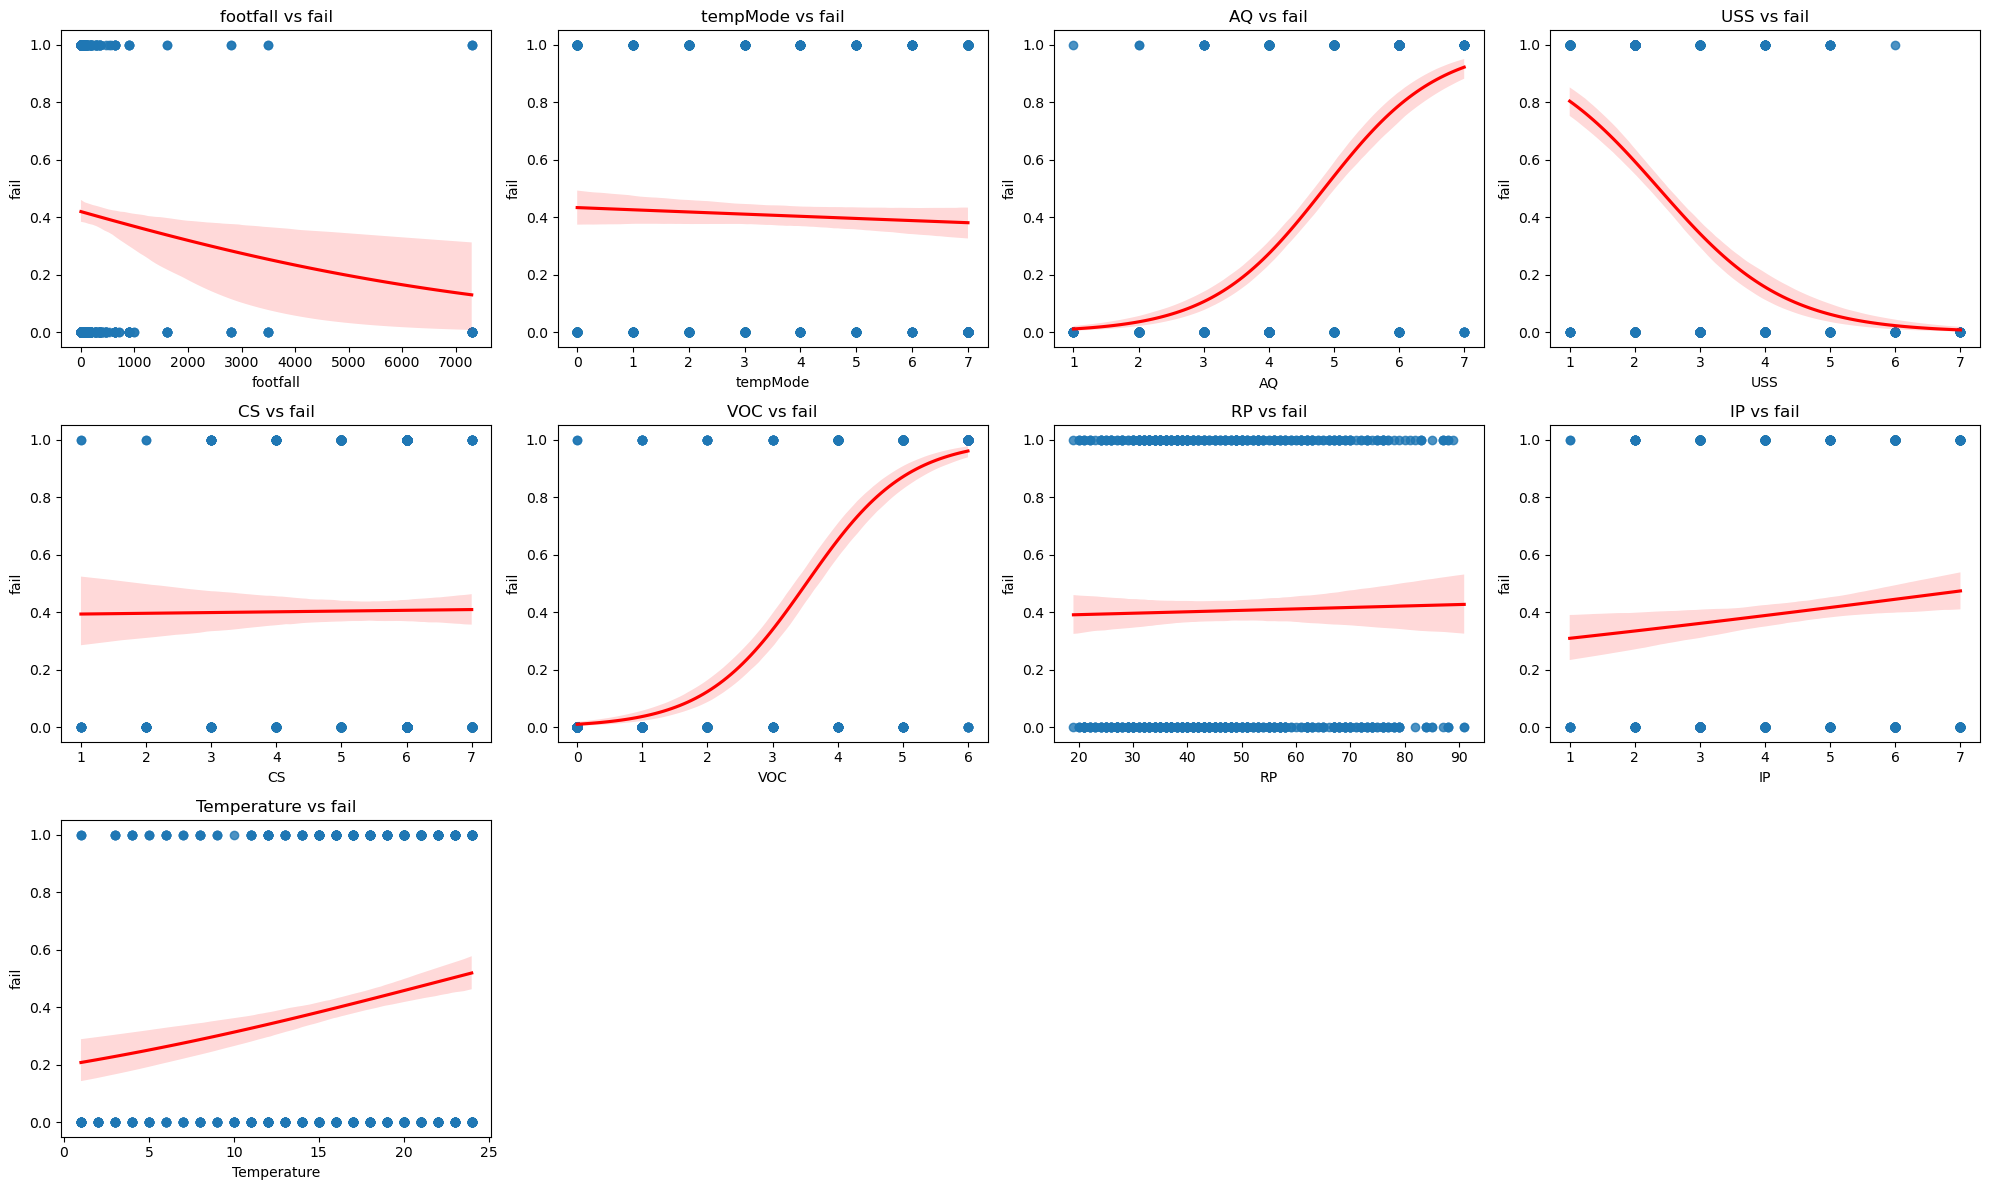

In [67]:
#linear trend for logistic regression?

#uses replot() to plot multiplie subplots in a grid. 

columns = [col for col in df.columns if col != 'fail']

#subplot
cols_per_row = 4
n_rows = 3

fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(5 * cols_per_row, 4 * n_rows))

for i, col in enumerate(columns):
    row = i // cols_per_row #which row we are on
    col_pos = i % cols_per_row #which col_position
    ax = axes[row, col_pos] if n_rows > 1 else axes[col_pos]

    # Logistic regression-like scatter + curve (approx)
    sns.regplot(x=col, y='fail', data=df, logistic=True, ax=ax, line_kws={'color': 'red'})
    ax.set_title(f'{col} vs fail')

# Hide any empty subplots (if number of columns isn't divisible by 4)
total_plots = n_rows * cols_per_row
for j in range(len(columns), total_plots):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()



The S-shape is ideal for logistic regression,  it models linear effects on the log-odds, and the sigmoid naturally handles the curve in probability space. Most promising features against logistic regression. 

The one which is flat or don't show a strong linear relationship with fail, then logistic regression may not find much information from them. 

Will check tree-based models, and other features. 